### Data cleaning OpenSky

In [ ]:
import pandas as pd
import json

In [ ]:
data2 = pd.read_csv("aircraft-database-complete-2022-11.csv", dtype= 'unicode')
data_filtered = data2.filter( items = ["icao_address", "tale_nb", "type_avion", "jet_prive", "serial_nb"])
airplane_tls = []
data_filtered_no_na = data_filtered.dropna(subset=['icao_address','type_avion'])
data_filtered_no_na.to_csv('new_opensky_11_2022.csv',na_rep='Unknown')

### Construire les listes des altitudes et vitesses

In [1]:
import pandas as pd
import json
import math
import datetime as dt

In [2]:

def haversine_distance(lat1, long1, lat2, long2):
    R = 6371  # radius of Earth in kilometers
    lat1, long1, lat2, long2 = map(math.radians, [lat1, long1, lat2, long2])
    dlat = lat2 - lat1
    dlong = long2 - long1
    a = (math.sin(dlat/2)**2) + math.cos(lat1) * math.cos(lat2) * (math.sin(dlong/2)**2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c
    return d

In [7]:
latitude_aero = 43.6293     #TOULOUSE
longitude_aero = 1.3676 
lat = 48.8567               #PARIS
long = 2.3508

distance = haversine_distance(latitude_aero, longitude_aero, lat, long)
print(distance)

586.14293769134


In [41]:
data = pd.read_csv(r'C:\Users\chell\Desktop\3SN\PL\ADSB\2022-11-25.csv.gz',compression='gzip', engine='python', error_bad_lines=False)

C:\Users\chell\AppData\Local\Temp\ipykernel_118828\3793182073.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(r'C:\Users\chell\Desktop\3SN\PL\ADSB\2022-11-25.csv.gz',compression='gzip', engine='python', error_bad_lines=False)


In [42]:

alt_list = []
lat_list = []
long_list = []
distance_aero_list = []
surf_list = []
rate_list = []
indice_list = []
flightid_list = []
sonore_list = []

latitude_aero = 43.6293
longitude_aero = 1.3676 

data['datetime'] = pd.to_datetime(data['timestamp_s'], unit='s')

for i in range (len(data)) :
   icao_addr = data.icao_adress_hex[i]
   jsn = data.data[i]
   jsn2 = json.loads(jsn)
   try:
      alt = jsn2["05_Altitude (ft)"]
      long = jsn2["05_Airborne Longitude (°)"]
      lat = jsn2["05_Airborne Latitude (°)"]
      vitesse_surf = jsn2["09_Surface Speed Calculated (knots)"]
      vitesse_rate = jsn2["09_sub1_Vertical Rate_Meaning"]
      flight_id = jsn2["08_Flight_ID"]
      air_sol = jsn2["AIR_SOL"]
      if (air_sol == 'SOL') : 
         indice_list.append(icao_addr)

      #calcul de la distance
      distance = haversine_distance(latitude_aero, longitude_aero, lat, long)
      
      #calcul du niveau sonore
      niveau = 57 + 20 * math.log10(vitesse_surf) - 15 * math.log10(alt) - 2 * math.log10(distance)

      if (vitesse_rate == "ZERO") : 
         rate_list.append(0)
      else :
         vitesse_split = vitesse_rate.split()
         if (vitesse_split[0] == "-") : 
            rate_list.append(-int(vitesse_split[1]))
         else : 
            rate_list.append(int(vitesse_split[1]))


      alt_list.append(alt)
      long_list.append(long)
      lat_list.append(lat)
      distance_aero_list.append(distance)
      surf_list.append(int(vitesse_surf))
      flightid_list.append(flight_id)
      sonore_list.append(niveau)
      
   except:
      #print("erreur")
      alt_list.append(-100)
      long_list.append(-100)
      lat_list.append(-100)
      surf_list.append(-100)
      rate_list.append(-100)
      distance_aero_list.append(-100)
      sonore_list.append(-100)
      flightid_list.append("")     # A verifier


data.loc[:, 'altitude'] = alt_list
data.loc[:, 'longitude'] = long_list
data.loc[:, 'latitude'] = lat_list
data.loc[:, 'distance_aero'] = distance_aero_list
data.loc[:, 'TAS'] = surf_list
data.loc[:, 'vertical_rate'] = rate_list
data.loc[:, 'Flight_ID'] = flightid_list
data.loc[:, 'niveau_sonore'] = sonore_list



data.drop(data[data['altitude']==-100].index,  inplace = True)
data = data.dropna(subset=['longitude','latitude'])

data

,icao_adress_hex,timestamp_s,data,datetime,altitude,longitude,latitude,distance_aero,TAS,vertical_rate,Flight_ID,niveau_sonore
0,30019c,1669420799,"{""05_Airborne Latitude (°)"":43.4029541015625,""...",2022-11-25 23:59:59,34025,0.980977,43.402954,40.067246,551,0,NOS4403,40.647399
1,4007f4,1669420799,"{""05_Airborne Latitude (°)"":42.42957163665254,...",2022-11-25 23:59:59,35000,2.019504,42.429572,143.541036,458,0,BAW59,37.749556
3,471a76,1669420799,"{""05_Airborne Latitude (°)"":43.359359482587394...",2022-11-25 23:59:59,21000,0.120457,43.359359,104.982614,213,0,FRF901,34.730190
4,600828,1669337981,"{""05_Airborne Latitude (°)"":46.352142333984375...",2022-11-25 00:59:41,32000,0.826520,46.352142,305.739357,415,64,AZQ4116,36.821273
5,34648d,1669337980,"{""05_Airborne Latitude (°)"":46.79081726074219,...",2022-11-25 00:59:40,31000,2.061410,46.790817,355.717181,395,0,SWN5629,36.471426
...,...,...,...,...,...,...,...,...,...,...,...,...
4212078,3cc00c,1669258149,"{""05_Airborne Latitude (°)"":43.57447737354343,...",2022-11-24 02:49:09,9975,0.878252,43.574477,39.871814,267,0,AZE41B,42.347392
4212079,44ccc3,1669258149,"{""05_Airborne Latitude (°)"":43.80807650291313,...",2022-11-24 02:49:09,40000,-1.556004,43.808077,235.783049,495,0,BEL359R,37.118004
4212080,484410,1669258149,"{""05_Airborne Latitude (°)"":43.35772705078125,...",2022-11-24 02:49:09,40000,1.359494,43.357727,30.204612,429,0,KLM588,37.660010
4212083,3cc00c,1669258148,"{""05_Airborne Latitude (°)"":43.574432373046875...",2022-11-24 02:49:08,9975,0.876607,43.574432,40.003538,267,0,AZE41B,42.344527


In [43]:
indice_list = [*set(indice_list)]
print(len(indice_list))
indice_list

100


['3801da',
 '380c5a',
 '38a05b',
 '396677',
 '3c658c',
 '44ce62',
 '3c5eec',
 '395d67',
 '45ce56',
 '389e1b',
 '4401c3',
 '4d225f',
 '38a03b',
 '398101',
 '3810ba',
 '3c6447',
 '39c466',
 '394ea2',
 '440051',
 '49529a',
 '3950c9',
 '3991e1',
 '4401d1',
 '484f80',
 '388e5b',
 '0a0022',
 '394c0a',
 '3c6743',
 '405ee0',
 '3461ce',
 '3b77ed',
 '3894db',
 '44ce6e',
 '02a1b3',
 '400a26',
 '3985a9',
 '0a0076',
 '39ac45',
 '345583',
 '380fda',
 '39b96e',
 '3c6597',
 '4cafc2',
 '440128',
 '38181a',
 '3451d8',
 '3c6748',
 '4401e4',
 'e49a46',
 '3946e1',
 '34648d',
 '3944f0',
 '398570',
 '3985a5',
 '394a63',
 '394a65',
 '45ab44',
 '3950cc',
 'a24f34',
 '3461cf',
 '395d69',
 '394c14',
 '3950d0',
 '3c70b1',
 '3985a7',
 '394a62',
 '34364e',
 '38137a',
 '44ce6f',
 '484c1b',
 '4ca737',
 '440036',
 '495212',
 '4ca7b7',
 '393324',
 '39e686',
 '39a56f',
 '39b40a',
 '3c6443',
 '398569',
 '394c10',
 '3950ce',
 '3817fa',
 '38185a',
 '393322',
 '3c644c',
 '406ae3',
 '440172',
 '38c53b',
 '020145',
 '388ddb',

In [44]:
#icao_liste = data.iloc[indice_list].icao_adress_hex.drop_duplicates()
#indice_list.drop_duplicates()
data = data[ data['icao_adress_hex'].isin(indice_list) ]
data

,icao_adress_hex,timestamp_s,data,datetime,altitude,longitude,latitude,distance_aero,TAS,vertical_rate,Flight_ID,niveau_sonore
5,34648d,1669337980,"{""05_Airborne Latitude (°)"":46.79081726074219,...",2022-11-25 00:59:40,31000,2.061410,46.790817,355.717181,395,0,SWN5629,36.471426
7,34648d,1669337979,"{""05_Airborne Latitude (°)"":46.79277323060116,...",2022-11-25 00:59:39,31000,2.061653,46.792773,355.934879,395,0,SWN5629,36.470895
9,34648d,1669337978,"{""05_Airborne Latitude (°)"":46.79277323060116,...",2022-11-25 00:59:38,31000,2.061653,46.792773,355.934879,395,0,SWN5629,36.470895
12,34648d,1669337976,"{""05_Airborne Latitude (°)"":46.79658508300781,...",2022-11-25 00:59:36,31000,2.062147,46.796585,356.359387,395,0,SWN5629,36.469859
14,34648d,1669337975,"{""05_Airborne Latitude (°)"":46.79859226032839,...",2022-11-25 00:59:35,31000,2.062408,46.798592,356.582930,395,0,SWN5629,36.469315
...,...,...,...,...,...,...,...,...,...,...,...,...
4152084,394ea2,1669265774,"{""05_Airborne Latitude (°)"":43.49026437533104,...",2022-11-24 04:56:14,19000,3.366329,43.490264,161.789965,337,0,TJT15ST,38.971746
4152138,394ea2,1669265764,"{""05_Airborne Latitude (°)"":43.49026437533104,...",2022-11-24 04:56:04,19000,3.366329,43.490264,161.789965,337,0,TJT15ST,38.971746
4152170,394ea2,1669265758,"{""05_Airborne Latitude (°)"":43.49026437533104,...",2022-11-24 04:55:58,19000,3.366329,43.490264,161.789965,337,0,TJT15ST,38.971746
4152228,394ea2,1669265748,"{""05_Airborne Latitude (°)"":43.49026437533104,...",2022-11-24 04:55:48,19000,3.366329,43.490264,161.789965,337,0,TJT15ST,38.971746


In [45]:
data_filter = data.filter( items = ["icao_adress_hex", "Flight_ID", "timestamp_s", "datetime", "altitude", "longitude", "latitude", "distance_aero", "TAS", "vertical_rate", "niveau_sonore"])
data_group = data_filter.groupby(['icao_adress_hex', 'Flight_ID']).agg(lambda x: x.tolist())
len(data_group)
data_group

timestamp_s  \
icao_adress_hex Flight_ID                                                      
020145          MAC341H    [1669283573, 1669276498, 1669276497, 166927649...   
                MAC342     [1669300860, 1669300859, 1669286110, 166928610...   
                MAC357E    [1669302848, 1669302838, 1669302833, 166930283...   
                MAC358A    [1669308262, 1669308257, 1669308256, 166930825...   
02a1b3          LBT514     [1669306536, 1669306535, 1669306534, 166930653...   
...                                                                      ...   
4d225f          RYR73YN    [1669322083, 1669322081, 1669322077, 166932207...   
                RYR865H    [1669287780, 1669287779, 1669287778, 166928777...   
                RYR98YA    [1669306347, 1669306346, 1669306344, 166930634...   
                RYR9ME     [1669308892, 1669308890, 1669308889, 166930888...   
a24f34          N248RF     [1669310294, 1669310292, 1669310290, 166931028...   

                                                                    datetime  \
icao_adress_hex Flight_ID                                                      
020145          MAC341H    [2022-11-24 09:52:53, 2022-11-24 07:54:58, 202...   
                MAC342     [2022-11-24 14:41:00, 2022-11-24 14:40:59, 202...   
                MAC357E    [2022-11-24 15:14:08, 2022-11-24 15:13:58, 202...   
                MAC358A    [2022-11-24 16:44:22, 2022-11-24 16:44:17, 202...   
02a1b3          LBT514     [2022-11-24 16:15:36, 2022-11-24 16:15:35, 202...   
...                                                                      ...   
4d225f          RYR73YN    [2022-11-24 20:34:43, 2022-11-24 20:34:41, 202...   
                RYR865H    [2022-11-24 11:03:00, 2022-11-24 11:02:59, 202...   
                RYR98YA    [2022-11-24 16:12:27, 2022-11-24 16:12:26, 202...   
                RYR9ME     [2022-11-24 16:54:52, 2022-11-24 16:54:50, 202...   
a24f34          N248RF     [2022-11-24 17:18:14, 2022-11-24 17:18:12, 202...   

                                                                    altitude  \
icao_adress_hex Flight_ID                                                      
020145          MAC341H    [28825, 24975, 24975, 24975, 25025, 25025, 250...   
                MAC342     [38000, 38000, 35000, 35000, 35000, 35000, 350...   
                MAC357E    [425, 425, 425, 425, 425, 425, 425, 425, 425, ...   
                MAC358A    [37000, 37000, 37000, 37025, 37000, 37000, 370...   
02a1b3          LBT514     [400, 400, 400, 400, 400, 400, 400, 400, 400, ...   
...                                                                      ...   
4d225f          RYR73YN    [35000, 35000, 35000, 35000, 35000, 35000, 350...   
                RYR865H    [325, 325, 325, 325, 325, 325, 325, 325, 325, ...   
                RYR98YA    [38000, 38000, 38000, 38000, 38000, 38000, 380...   
                RYR9ME     [400, 400, 400, 400, 400, 400, 400, 400, 400, ...   
a24f34          N248RF     [34000, 34000, 34000, 34000, 34000, 34000, 340...   

                                                                   longitude  \
icao_adress_hex Flight_ID                                                      
020145          MAC341H    [5.154353550502232, 4.839281354631696, 4.83928...   
                MAC342     [-1.6514622887899577, -1.6514622887899577, 1.6...   
                MAC357E    [1.3541303362165178, 1.3541303362165178, 1.354...   
                MAC358A    [-1.2320656000181316, -1.2320656000181316, -1....   
02a1b3          LBT514     [1.3538094454033431, 1.3538094454033431, 1.353...   
...                                                                      ...   
4d225f          RYR73YN    [2.2004241943359375, 2.2004241943359375, 2.200...   
                RYR865H    [1.354384311409884, 1.354384311409884, 1.35438...   
                RYR98YA    [-1.6485879587572185, -1.6516539107921062, -1....   
                RYR9ME     [1.3556998116629464, 1.355699811662

In [47]:
#calcul de l'indice de performance sonore

def sum_sonore(x):
    return 10**(x/10)

list_indice = []
for i in range (len(data_group)) :
   
    list_niv = list(map(sum_sonore, data_group['niveau_sonore'][i]))
    indice_perfo = 10*math.log10(sum(list_niv))
    list_indice.append(indice_perfo)


data_group.loc[:, 'indice_sonore'] = list_indice

data_group = data_group.drop(columns=['niveau_sonore'])

data_group

timestamp_s  \
icao_adress_hex Flight_ID                                                      
020145          MAC341H    [1669283573, 1669276498, 1669276497, 166927649...   
                MAC342     [1669300860, 1669300859, 1669286110, 166928610...   
                MAC357E    [1669302848, 1669302838, 1669302833, 166930283...   
                MAC358A    [1669308262, 1669308257, 1669308256, 166930825...   
02a1b3          LBT514     [1669306536, 1669306535, 1669306534, 166930653...   
...                                                                      ...   
4d225f          RYR73YN    [1669322083, 1669322081, 1669322077, 166932207...   
                RYR865H    [1669287780, 1669287779, 1669287778, 166928777...   
                RYR98YA    [1669306347, 1669306346, 1669306344, 166930634...   
                RYR9ME     [1669308892, 1669308890, 1669308889, 166930888...   
a24f34          N248RF     [1669310294, 1669310292, 1669310290, 166931028...   

                                                                    datetime  \
icao_adress_hex Flight_ID                                                      
020145          MAC341H    [2022-11-24 09:52:53, 2022-11-24 07:54:58, 202...   
                MAC342     [2022-11-24 14:41:00, 2022-11-24 14:40:59, 202...   
                MAC357E    [2022-11-24 15:14:08, 2022-11-24 15:13:58, 202...   
                MAC358A    [2022-11-24 16:44:22, 2022-11-24 16:44:17, 202...   
02a1b3          LBT514     [2022-11-24 16:15:36, 2022-11-24 16:15:35, 202...   
...                                                                      ...   
4d225f          RYR73YN    [2022-11-24 20:34:43, 2022-11-24 20:34:41, 202...   
                RYR865H    [2022-11-24 11:03:00, 2022-11-24 11:02:59, 202...   
                RYR98YA    [2022-11-24 16:12:27, 2022-11-24 16:12:26, 202...   
                RYR9ME     [2022-11-24 16:54:52, 2022-11-24 16:54:50, 202...   
a24f34          N248RF     [2022-11-24 17:18:14, 2022-11-24 17:18:12, 202...   

                                                                    altitude  \
icao_adress_hex Flight_ID                                                      
020145          MAC341H    [28825, 24975, 24975, 24975, 25025, 25025, 250...   
                MAC342     [38000, 38000, 35000, 35000, 35000, 35000, 350...   
                MAC357E    [425, 425, 425, 425, 425, 425, 425, 425, 425, ...   
                MAC358A    [37000, 37000, 37000, 37025, 37000, 37000, 370...   
02a1b3          LBT514     [400, 400, 400, 400, 400, 400, 400, 400, 400, ...   
...                                                                      ...   
4d225f          RYR73YN    [35000, 35000, 35000, 35000, 35000, 35000, 350...   
                RYR865H    [325, 325, 325, 325, 325, 325, 325, 325, 325, ...   
                RYR98YA    [38000, 38000, 38000, 38000, 38000, 38000, 380...   
                RYR9ME     [400, 400, 400, 400, 400, 400, 400, 400, 400, ...   
a24f34          N248RF     [34000, 34000, 34000, 34000, 34000, 34000, 340...   

                                                                   longitude  \
icao_adress_hex Flight_ID                                                      
020145          MAC341H    [5.154353550502232, 4.839281354631696, 4.83928...   
                MAC342     [-1.6514622887899577, -1.6514622887899577, 1.6...   
                MAC357E    [1.3541303362165178, 1.3541303362165178, 1.354...   
                MAC358A    [-1.2320656000181316, -1.2320656000181316, -1....   
02a1b3          LBT514     [1.3538094454033431, 1.3538094454033431, 1.353...   
...                                                                      ...   
4d225f          RYR73YN    [2.2004241943359375, 2.2004241943359375, 2.200...   
                RYR865H    [1.354384311409884, 1.354384311409884, 1.35438...   
                RYR98YA    [-1.6485879587572185, -1.6516539107921062, -1....   
                RYR9ME     [1.3556998116629464, 1.355699811662

In [48]:
data_group.to_csv('data11/data_group_25-11.csv')

### Jointure : données ADSB avec OpenSky

In [56]:
import pandas as pd

csv_ADSB = 'data11/data_group_27-11.csv'
data = pd.read_csv(csv_ADSB)

data2 = pd.read_csv("new_opensky_11_2022.csv")
data_new = data2.set_index('icao_address').join(data.set_index('icao_adress_hex'))

data_new_na = data_new.dropna(subset=['timestamp_s','altitude', 'TAS', 'vertical_rate'])

data_new_na = data_new_na.loc[:, ~data_new_na.columns.str.contains('^Unnamed')]

#data_new_na.to_csv('data_join.csv')
data_new_na.to_csv('data11/data_join_27-11.csv')

print(len(data_new_na))
data_new_na



1


,tale_nb,type_avion,jet_prive,serial_nb,Flight_ID,timestamp_s,datetime,altitude,longitude,latitude,distance_aero,TAS,vertical_rate,indice_sonore
icao_address,,,,,,,,,,,,,,
3461ce,EC-NDG,A319,Unknown,Unknown,VOE2761,"[1669502889, 1669502887, 1669502886, 166950288...","[Timestamp('2022-11-26 22:48:09'), Timestamp('...","[100, 100, 100, 100, 100, 100, 100, 100, 100, ...","[1.3515099813771803, 1.3515099813771803, 1.351...","[43.6387939453125, 43.6387939453125, 43.638793...","[1.6706978030141406, 1.6706978030141406, 1.670...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, ...","[-128, -128, -128, -128, -128, -128, -128, -12...",82.274516


### OpenAP : Calcul des indicateurs environnementaux

In [15]:
import numpy as np
import ast
import matplotlib.pyplot as plt
from openap import Emission, FuelFlow, prop
from mpl_toolkits.mplot3d import Axes3D

In [17]:
aircraft = prop.aircraft('b734')      #pour vérifier si openap est bien installé
data_new_na = pd.read_csv("data11/data_join_25-11.csv")

In [19]:
def indicateurs_env(ac, tas, alt) : 
        
    aircraft = prop.aircraft(ac)
    fuelflow = FuelFlow(ac=ac)
    emission = Emission(ac=ac)

    tas_, alt_ = np.meshgrid(tas, alt)
    mass = aircraft["limits"]["MTOW"] * 0.85


    ff = fuelflow.enroute(mass=mass, tas=tas_, alt=alt_, path_angle=0)

    co2 = emission.co2(ff)
    h2o = emission.h2o(ff)
    sox = emission.sox(ff)
    nox = emission.nox(ff, tas=tas_, alt=alt_)
    co = emission.co(ff, tas=tas_, alt=alt_)
    hc = emission.hc(ff, tas=tas_, alt=alt_)

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    surf = ax.plot_surface(tas_, alt_, ff)
    plt.title("fuel flow (kg/s)")
    plt.xlabel("TAS (kt)")
    plt.ylabel("Altitude (ft)")
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    surf = ax.plot_surface(tas_, alt_, h2o)
    plt.title("H2O (g/s)")
    plt.xlabel("TAS (kt)")
    plt.ylabel("Altitude (ft)")
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    surf = ax.plot_surface(tas_, alt_, co2)
    plt.title("CO2 (kg/s)")
    plt.xlabel("TAS (kt)")
    plt.ylabel("Altitude (ft)")
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    surf = ax.plot_surface(tas_, alt_, sox)
    plt.title("SOx (g/s)")
    plt.xlabel("TAS (kt)")
    plt.ylabel("Altitude (ft)")
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    surf = ax.plot_surface(tas_, alt_, nox)
    plt.title("NOx (g/s)")
    plt.xlabel("TAS (kt)")
    plt.ylabel("Altitude (ft)")
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    surf = ax.plot_surface(tas_, alt_, co)
    plt.title("CO (g/s)")
    plt.xlabel("TAS (kt)")
    plt.ylabel("Altitude (ft)")
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    surf = ax.plot_surface(tas_, alt_, hc)
    plt.title("HC (g/s)")
    plt.xlabel("TAS (kt)")
    plt.ylabel("Altitude (ft)")
    plt.show()

In [20]:
def indicateurs_env_ligne(data, nb):

    list_type = data.type_avion
    list_tas = data.TAS
    list_alt = data.altitude

    ac = list_type[nb]
    tas = ast.literal_eval(list_tas[nb])
    alt = ast.literal_eval(list_alt[nb])

    indicateurs_env(ac, tas, alt)

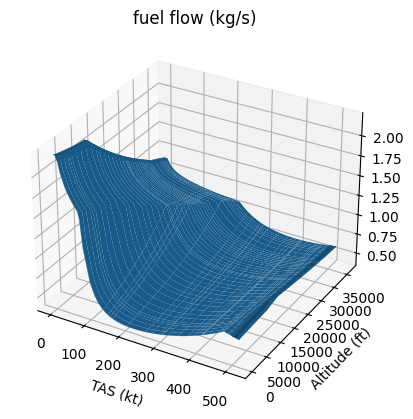

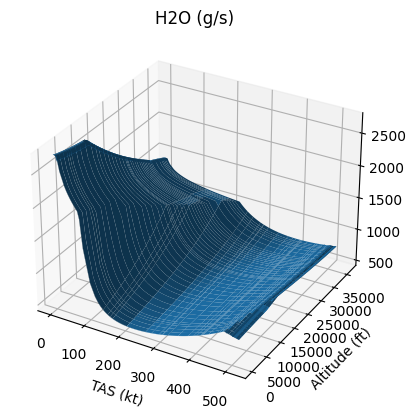

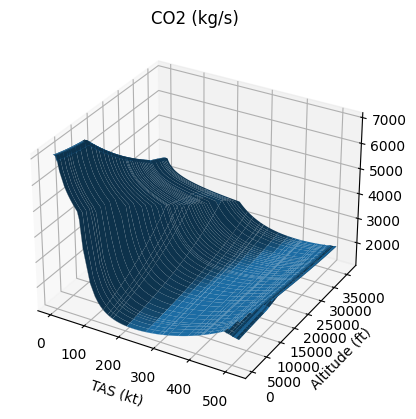

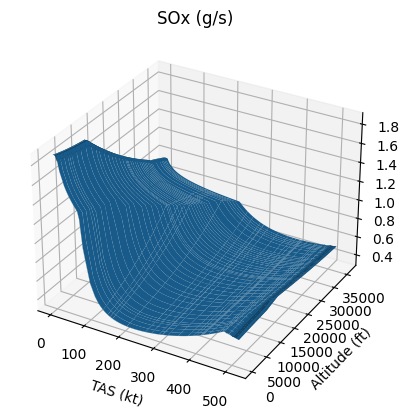

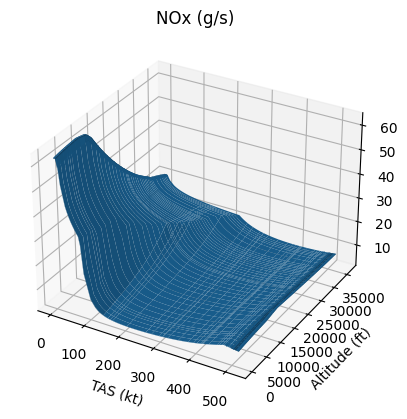

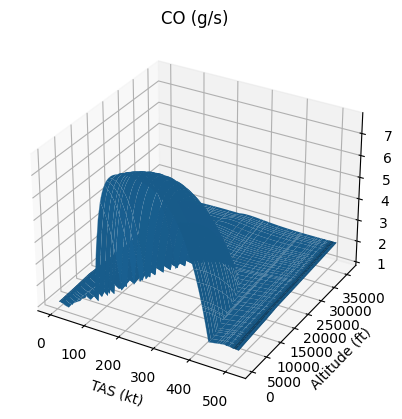

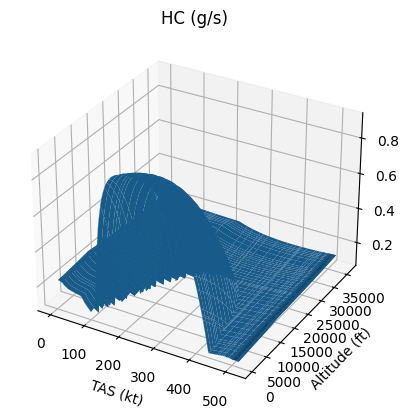

In [24]:
nb_ligne = 5
indicateurs_env_ligne(data_new_na, nb_ligne)

### Base de données pour classifier les indicateurs environnementaux

In [8]:
from openap import prop
import ast
import numpy as np
import matplotlib.pyplot as plt
from openap import Emission, FuelFlow, prop
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import json
import math

data_new_na = pd.read_csv("data11/data_toulouse_25_11.csv")

In [9]:

def indicateurs(ac, tas, alt) : 
        
    aircraft = prop.aircraft(ac)
    fuelflow = FuelFlow(ac=ac)
    emission = Emission(ac=ac)

    tas_, alt_ = np.meshgrid(tas, alt)
    mass = aircraft["limits"]["MTOW"] * 0.85


    ff = fuelflow.enroute(mass=mass, tas=tas_, alt=alt_, path_angle=0)
    ff = np.array(ff)

    co2 = emission.co2(ff)
    h2o = emission.h2o(ff)
    sox = emission.sox(ff)
    nox = emission.nox(ff, tas=tas_, alt=alt_)
    co = emission.co(ff, tas=tas_, alt=alt_)
    hc = emission.hc(ff, tas=tas_, alt=alt_)

    return np.mean(ff), np.mean(co2), np.mean(h2o), np.mean(sox), np.mean(nox), np.mean(co), np.mean(hc)

In [10]:
list_type = data_new_na.type_avion
list_tas = data_new_na.TAS
list_alt = data_new_na.altitude

#créer une dataframe :
df_conso = pd.DataFrame(columns=['type_avion', 'consommation_carburant'])
df_emission = pd.DataFrame(columns=['type_avion', 'emission_co2', 'emission_h2o', 'emission_sox', 'emission_nox', 'emission_co', 'emission_hc'])


In [39]:
ac = list_type[5]

aircraft = prop.aircraft(ac)
fuelflow = FuelFlow(ac=ac)
emission = Emission(ac=ac)


tas = ast.literal_eval(list_tas[5])
alt = ast.literal_eval(list_alt[5])

ff, co2, h2o, sox, nox, co, hc = indicateurs(ac, tas, alt)
print(ff)
print(co2)
print(h2o)

0.5482482456046812
1726.4337254091413
674.345342093758


In [11]:

for i in range (len(list_type)) : 
    print(i)
    try : 

        ac = list_type[i]

        aircraft = prop.aircraft(ac)
        fuelflow = FuelFlow(ac=ac)
        emission = Emission(ac=ac)

        tas = ast.literal_eval(list_tas[i])
        alt = ast.literal_eval(list_alt[i])

        ff, co2, h2o, sox, nox, co, hc = indicateurs(ac, tas, alt)
        
        df_conso.loc[i] = [ac, ff]
        df_emission.loc[i] = [ac, co2, h2o, sox, nox, co, hc]

    except:

        print('erreur')

df_conso

0
1
2
3
4
5
6
7
8
erreur
9
erreur
10
erreur
11
erreur
12
erreur
13
erreur
14
15
16
17
18
19
20
erreur
21
erreur
22
erreur
23
erreur
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
erreur
46
erreur
47
erreur
48
erreur
49
erreur
50
51
52
53
54
55
56
erreur
57
erreur
58
erreur
59
erreur
60
erreur
61
erreur
62
erreur
63
erreur
64
erreur
65
erreur
66
erreur
67
erreur
68
erreur
69
erreur
70
erreur
71
erreur
72
erreur
73
erreur
74
erreur
75
erreur
76
erreur
77
erreur
78
erreur
79
erreur
80
erreur
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
erreur
103
erreur
104
erreur
105
erreur
106
erreur
107
erreur
108
erreur
109
erreur
110
erreur
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
erreur
154
erreur
155
erreur
156
157
158
159
160
161
erreur
162
erreur
163
164
165
166
167
168
169
170
erreur
171
erreur
172
erreur


,type_avion,consommation_carburant
0,A320,0.739266
1,A320,0.670882
2,A320,0.727441
3,A320,0.784117
4,B738,0.734349
...,...,...
165,B738,0.758881
166,B738,0.835246
167,B738,0.659394
168,B738,0.700801


In [12]:
df_emission

,type_avion,emission_co2,emission_h2o,emission_sox,emission_nox,emission_co,emission_hc
0,A320,2327.949095,909.297360,0.620984,10.593858,2.398166,0.215588
1,A320,2112.608951,825.185459,0.563541,9.049850,2.627977,0.237714
2,A320,2290.711455,894.752331,0.611050,11.418445,3.453163,0.361796
3,A320,2469.183937,964.463716,0.658658,12.312122,2.287122,0.206377
4,B738,2312.463539,903.248699,0.616853,10.815444,2.157171,0.203171
...,...,...,...,...,...,...,...
165,B738,2389.714734,933.423030,0.637460,11.521013,1.884785,0.176457
166,B738,2630.190901,1027.353067,0.701607,13.699641,1.672803,0.165827
167,B738,2076.431047,811.054362,0.553891,7.896958,1.743707,0.142285
168,B738,2206.823160,861.985547,0.588673,8.760895,1.708452,0.139890


In [13]:
df_conso.to_csv('data11/aircraft_consommations_data-25-11.csv')
df_emission.to_csv('data11/aircraft_emissions_data-25-11.csv')